**Find the ground state energy of a certain Hamiltonian with SDP:**
1. We can somehow prepare the groud state $\rho_g$ of a Hamiltonian $H$
2. We do quantum tomography on this prepared state $\rho_g$ and get an approximation $\hat{\rho}$
3. By using SDP, we get a physically valid quantum state $\hat{\rho}_{SDP}$ which minimizes $\text{Tr}(\rho H)$ for $\rho \in \tilde{\rho}$
4. The ground state energy we find is then $\text{Tr}(H\hat{\rho}_{SDP})$

In [10]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor

from SDPforVQE import generate_PauliStrList, Hamiltonian_global, Hamiltonian_matrix, ground_state, lower_bound_with_SDP, N_meas_list_func
from SDPforVQE import get_SDP_dataset_min, get_SDP_dataset_max, process_SDP_dataset

In [20]:
model_type = 'closed'
#model_type = 'open'

N = 3 # Number of qubits of the entire system
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N
P = 4**M-1 # Number of Pauli basis for each subsystem

PauliStrList = generate_PauliStrList(N)[1:]
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]

H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system

ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 
q_state = DensityMatrix(ground_state_dm) 
lower_bound = lower_bound_with_SDP(H_local_matrix, N, M, G, K, P, PauliStrList_part, PauliStrList_Gbody, model_type)

num_data_point = 3 # number of N_meas that we select to run
N_meas_list = N_meas_list_func(100, 500, num_data_point) # A list of number of measurement performed in all basis
num_of_shot = 2 # Number of repeatation of the experiment


# Import the dataset of SDP results
threshold_max = 0.001 
filename_max = model_type + '_N' + str(N) + '_threshold' + str(threshold_max) + '_max'
path_upper = f'result_data/{filename_max}.npy'
data_upper = np.load(path_upper, allow_pickle=True)
data_upper = data_upper.item()
E_mean_max, E_std_max = process_SDP_dataset(data_upper, num_of_shot, num_data_point)

threshold_min = 0.001 
filename_min = model_type + '_N' + str(N) + '_threshold' + str(threshold_min) + '_min'
path_lower = f'result_data/{filename_min}.npy'
data_lower = np.load(path_lower, allow_pickle=True)
data_lower = data_lower.item()
E_mean_min, E_std_min = process_SDP_dataset(data_lower, num_of_shot, num_data_point)

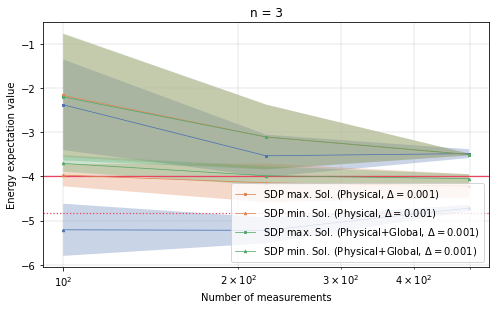

In [22]:
plt.figure(figsize=(8, 4.5))
label_1 = "Ground State Energy (Theoretical)"
label_2 = "Ground State Energy (Relaxation Method)"
label_3 = "Exp. Avg. Upper Bound (99% CI)"
label_4 = "Exp. Avg. Lower Bound (99% CI)"
label_5 = f"SDP max. Sol. (Physical, $\\Delta={threshold_max}$)"
label_6 = f"SDP min. Sol. (Physical, $\\Delta={threshold_min}$)"
label_7 = f"SDP max. Sol. (Physical+Global, $\\Delta={threshold_max}$)"
label_8 = f"SDP min. Sol. (Physical+Global, $\\Delta={threshold_min}$)"

plt.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1.25, label=label_1)
plt.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1.25, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
c3, = plt.plot(N_meas_list, E_mean_min['E_max'], color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
c4, = plt.plot(N_meas_list, E_mean_min['E_min'], color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
c5, = plt.plot(N_meas_list, E_mean_max['E_max_C0'], color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
c6, = plt.plot(N_meas_list, E_mean_min['E_min_C0'], color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
c7, = plt.plot(N_meas_list, E_mean_max['E_max_C01'], color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
c8, = plt.plot(N_meas_list, E_mean_min['E_min_C01'], color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_8)

# Draw the shades
z = norm.ppf(1-0.05/2)
plt.fill_between(N_meas_list, E_mean_min['E_min']-z*E_std_min['E_min'], E_mean_min['E_min']+z*E_std_min['E_min'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_max']-z*E_std_min['E_max'], E_mean_min['E_max']+z*E_std_min['E_max'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_max['E_max_C0']-z*E_std_max['E_max_C0'], E_mean_max['E_max_C0']+z*E_std_max['E_max_C0'], facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_min_C0']-z*E_std_min['E_min_C0'], E_mean_min['E_min_C0']+z*E_std_min['E_min_C0'], facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_max['E_max_C01']-z*E_std_max['E_max_C01'], E_mean_max['E_max_C01']+z*E_std_max['E_max_C01'], facecolor=color_code_list[4], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_min_C01']-z*E_std_min['E_min_C01'], E_mean_min['E_min_C01']+z*E_std_min['E_min_C01'], facecolor=color_code_list[4], alpha=0.3)

# # Create two separate legend objects
# legend1 = plt.legend([label_1, label_2, label_3, label_4], loc='lower right')

# Assuming you have threshold_upper and threshold_lower values defined
legend2 = plt.legend([c5, c6, c7, c8], [label_5, label_6, label_7, label_8], loc='lower right')

# # Add both legend objects to the plot using add_artist()
# plt.gca().add_artist(legend1)
# plt.gca().add_artist(legend2)

plt.xscale('log')
plt.title('n = %s' % N)
plt.xlabel('Number of measurements')
plt.ylabel('Energy expectation value')
plt.grid(True, which="both", ls="-", linewidth=0.3)

figurename = 'data_N' + str(N) + '.pdf'
figurepath = f'figures/{figurename}'
#plt.savefig(figurepath, bbox_inches='tight')
plt.show()

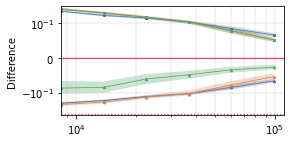

In [206]:
# Double log plots for large number of measurements

plt.figure(figsize=(4, 2))
label_1 = "Ground State Energy (Theoretical)"
label_2 = "Ground State Energy (Relaxation Method)"
label_3 = "Exp. Avg. Upper Bound (99% CI)"
label_4 = "Exp. Avg. Lower Bound (99% CI)"
label_5 = f"SDP max. Sol. (Physical, $\\Delta={threshold_max}$)"
label_6 = f"SDP min. Sol. (Physical, $\\Delta={threshold_min}$)"
label_7 = f"SDP max. Sol. (Physical+Global, $\\Delta={threshold_max}$)"
label_8 = f"SDP min. Sol. (Physical+Global, $\\Delta={threshold_min}$)"

plt.axhline(y = 0, color='#E94560', linestyle='-', linewidth=1.25, label=label_1)
plt.axhline(y = lower_bound-ground_state_energy, color='#E94560', linestyle=':', linewidth=1.25, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
d = 6
plt.plot(N_meas_list[-d:], E_mean_min['E_max'][-d:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
plt.plot(N_meas_list[-d:], E_mean_min['E_min'][-d:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
plt.plot(N_meas_list[-d:], E_mean_max['E_max_C0'][-d:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
plt.plot(N_meas_list[-d:], E_mean_min['E_min_C0'][-d:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
plt.plot(N_meas_list[-d:], E_mean_max['E_max_C01'][-d:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
plt.plot(N_meas_list[-d:], E_mean_min['E_min_C01'][-d:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_8)

# Draw the shades
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min'][-d:]-z*E_std_min['E_min'][-d:]-ground_state_energy, 
                 E_mean_min['E_min'][-d:]+z*E_std_min['E_min'][-d:]-ground_state_energy, facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_max'][-d:]-z*E_std_min['E_max'][-d:]-ground_state_energy, 
                 E_mean_min['E_max'][-d:]+z*E_std_min['E_max'][-d:]-ground_state_energy, facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_max['E_max_C0'][-d:]-z*E_std_max['E_max_C0'][-d:]-ground_state_energy, 
                 E_mean_max['E_max_C0'][-d:]+z*E_std_max['E_max_C0'][-d:]-ground_state_energy, facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min_C0'][-d:]-z*E_std_min['E_min_C0'][-d:]-ground_state_energy, 
                 E_mean_min['E_min_C0'][-d:]+z*E_std_min['E_min_C0'][-d:]-ground_state_energy, facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_max['E_max_C01'][-d:]-z*E_std_max['E_max_C01'][-d:]-ground_state_energy, 
                 E_mean_max['E_max_C01'][-d:]+z*E_std_max['E_max_C01'][-d:]-ground_state_energy, facecolor=color_code_list[4], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min_C01'][-d:]-z*E_std_min['E_min_C01'][-d:]-ground_state_energy, 
                 E_mean_min['E_min_C01'][-d:]+z*E_std_min['E_min_C01'][-d:]-ground_state_energy, facecolor=color_code_list[4], alpha=0.3)

plt.xscale('log')
plt.yscale('symlog', linthresh = 0.1)
plt.ylabel('Difference')
plt.xlim(8386)
plt.grid(True, which="both", ls="-", linewidth=0.3)

figurename = 'data_N' + str(N) + '_zoom' + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath, bbox_inches='tight')
plt.show()


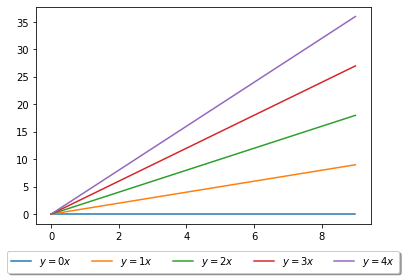

In [211]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)

fig = plt.figure()
ax = plt.subplot(111)

for i in range(5):
    line, = ax.plot(x, i * x, label='$y = %ix$'%i)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()

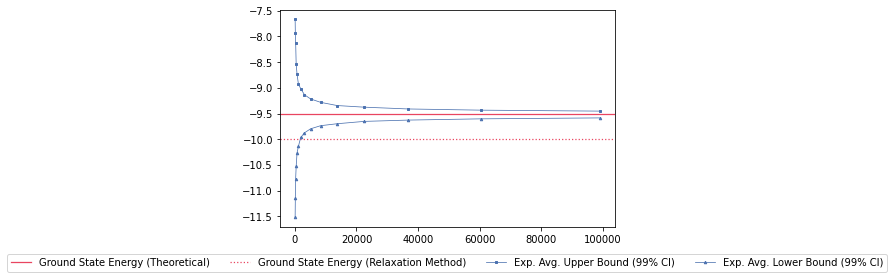

In [217]:
fig = plt.figure()
ax = plt.subplot(111)

ax.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1.25, label=label_1)
ax.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1.25, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
ax.plot(N_meas_list, E_mean_min['E_max'], color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
ax.plot(N_meas_list, E_mean_min['E_min'], color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=5)

figurename = 'legend' + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath, bbox_inches='tight')
plt.show()

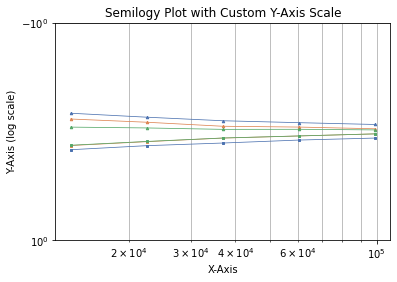

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = N_meas_list[-5:]
y = E_mean_min['E_max'][-5:]-ground_state_energy

# Create a figure and axis
fig, ax = plt.subplots()

# Set the y-axis to log scale
ax.semilogy(N_meas_list[-5:], E_mean_min['E_max'][-5:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min'][-5:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
ax.semilogy(N_meas_list[-5:], E_mean_max['E_max_C0'][-5:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min_C0'][-5:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
ax.semilogy(N_meas_list[-5:], E_mean_max['E_max_C01'][-5:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min_C01'][-5:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_8)



# Customize the y-axis scale with a linear threshold
ax.set_yscale('symlog')
ax.set_ylim(1, -1)
ax.set_xscale('log')
ax.grid(True, which="both", ls="-")

# Add labels and a title
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis (log scale)')
ax.set_title('Semilogy Plot with Custom Y-Axis Scale')

# Show the plot
plt.show()


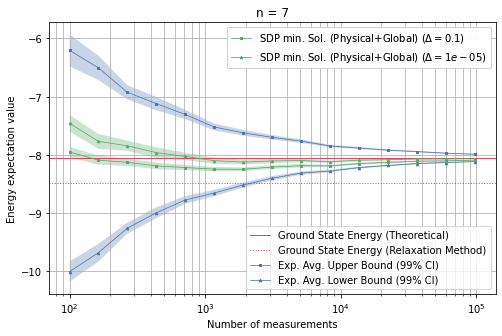

In [ ]:
plt.figure(figsize=(8, 5))
label_1 = "Ground State Energy (Theoretical)"
label_2 = "Ground State Energy (Relaxation Method)"
label_3 = "Exp. Avg. Upper Bound (99% CI)"
label_4 = "Exp. Avg. Lower Bound (99% CI)"
label_5 = f"SDP min. Sol. (Physical+Global) ($\\Delta={threshold_max}$)"
label_6 = f"SDP min. Sol. (Physical+Global) ($\\Delta={threshold_min}$)"
label_7 = f"SDP min. Sol. (Physical) ($\\Delta={threshold_max}$)"
label_8 = f"SDP min. Sol. (Physical) ($\\Delta={threshold_min}$)"

plt.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1, label=label_1)
plt.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
c3, = plt.plot(N_meas_list, E_mean_min['E_max'], color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
c4, = plt.plot(N_meas_list, E_mean_min['E_min'], color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
c5, = plt.plot(N_meas_list, E_mean_max['E_min_C01'], color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
c6, = plt.plot(N_meas_list, E_mean_min['E_min_C01'], color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
#c7, = plt.plot(N_meas_list, E_mean_max['E_min_C0'], color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
#c8, = plt.plot(N_meas_list, E_mean_min['E_min_C0'], color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_8)

# Draw the shades
plt.fill_between(N_meas_list, E_mean_min['E_min']-2.58*E_std_min['E_min'], E_mean_min['E_min']+2.58*E_std_min['E_min'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_max']-2.58*E_std_min['E_max'], E_mean_min['E_max']+2.58*E_std_min['E_max'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_max['E_min_C01']-2.58*E_std_max['E_min_C01'], E_mean_max['E_min_C01']+2.58*E_std_max['E_min_C01'], facecolor=color_code_list[4], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_min_C01']-2.58*E_std_min['E_min_C01'], E_mean_min['E_min_C01']+2.58*E_std_min['E_min_C01'], facecolor=color_code_list[4], alpha=0.3)
#plt.fill_between(N_meas_list, E_mean_max['E_min_C0']-2.58*E_std_max['E_min_C0'], E_mean_max['E_min_C0']+2.58*E_std_max['E_min_C0'], facecolor=color_code_list[2], alpha=0.3)
#plt.fill_between(N_meas_list, E_mean_min['E_min_C0']-2.58*E_std_min['E_min_C0'], E_mean_min['E_min_C0']+2.58*E_std_min['E_min_C0'], facecolor=color_code_list[2], alpha=0.3)

# for key in type_of_constraints:
#     i = type_of_constraints.index(key)
#     plt.fill_between(N_meas_list, E_mean_min[key]-2.58*E_std_min[key], E_mean_min[key]+2.58*E_std_min[key], facecolor=color_code_list[i], alpha=0.3)
# plt.fill_between(N_meas_list, E_mean_max['E_max_C01']-2.58*E_std_max['E_max_C01'], E_mean_max['E_max_C01']+2.58*E_std_max['E_max_C01'], facecolor=color_code_list[2], alpha=0.3)

# Create two separate legend objects
legend1 = plt.legend([label_1, label_2, label_3, label_4], loc='lower right')

# Assuming you have threshold_upper and threshold_lower values defined
legend2 = plt.legend([c5, c6], [label_5, label_6], loc='upper right')

# Add both legend objects to the plot using add_artist()
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.xscale('log')
plt.title('n = %s' % N)
plt.xlabel('Number of measurements')
plt.ylabel('Energy expectation value')
plt.grid(True, which="both", ls="-")

figurename = 'data_N' + str(N) + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath)
plt.show()

In [ ]:
N = 3 # Number of qubits of the entire system
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
K = N-M+1 # Number of subsystems
P = 4**M-1 # Number of Pauli basis for each subsystem

PauliStrList = generate_PauliStrList(N)[1:]
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]

H_local_list = ['XX','YY']
H_global_list = Hamiltonian_global(H_local_list, N, M, K)
H_local = np.array( Hamiltonian_matrix(H_local_list) ) # The local Hamiltonian of subsystems
H_global = np.array( Hamiltonian_matrix(H_global_list) ) # The global Hamiltonian of interest

ground_state_energy, ground_state_dm = ground_state(H_global)
q_state = DensityMatrix(ground_state_dm)
lower_bound = lower_bound_with_SDP(H_local, N, M, K, P)

num_data_point = 4 # number of N_meas that we select to run
N_meas_list = N_meas_list_func(100, 1000, num_data_point) # A list of number of measurement performed in all basis
num_of_shot = 5 # Number of repeatation of the experiment

# Import the dataset of SDP results
threshold_upper = 0.01 
filename_upper = 'data_N' + str(N) + '_threshold' + str(threshold_upper)
path_upper = f'{filename_upper}.npy'
data_upper = np.load(path_upper, allow_pickle=True)
data_upper = data_upper.item()
E_mean_upper, E_std_upper = process_SDP_dataset(data_upper, num_of_shot, num_data_point)

threshold_lower = 0.01 
filename_lower = 'data_N' + str(N) + '_threshold' + str(threshold_lower)
path_lower = f'{filename_lower}.npy'
data_lower = np.load(path_lower, allow_pickle=True)
data_lower = data_lower.item()
E_mean_lower, E_std_lower = process_SDP_dataset(data_lower, num_of_shot, num_data_point)

NameError: name 'E_mean_lower' is not defined

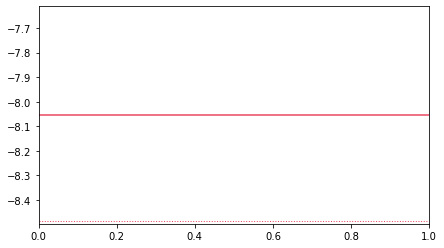

In [ ]:
plt.figure(figsize=(7, 4))
#plt.figure(dpi=400)
plt.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1.5, label='Theoretical GS energy')
plt.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1, label=label_2)

type_of_constraints = ['E_min', 'E_max', 'E_min_C0', 'E_max_C0', 'E_min_C01', 'E_max_C01']
color_code_list = ['#4c72b0', '#4c72b0', '#dd8452', '#dd8452', '#55a868', '#55a868']

plt.plot(N_meas_list, E_mean_lower['E_min'], color='#4c72b0', linewidth=1, marker='s', markersize=2, label='Statistical GS energy (99%)')
plt.plot(N_meas_list, E_mean_lower['E_max'], color='#4c72b0', linewidth=1, marker='s', markersize=2)
plt.plot(N_meas_list, E_mean_lower['E_min_C0'], color='#dd8452', linewidth=1, marker='^', markersize=2, label='Physical compatibility')
plt.plot(N_meas_list, E_mean_lower['E_max_C0'], color='#dd8452', linewidth=1, marker='^', markersize=2)
#plt.plot(N_meas_list, E_mean_lower['E_min_C1'], color='k', linewidth=1, marker='^', markersize=2, label='Global compatibility')
#plt.plot(N_meas_list, E_mean_lower['E_max_C1'], color='k', linewidth=1, marker='^', markersize=2)
plt.plot(N_meas_list, E_mean_lower['E_min_C01'], color='#55a868', linewidth=1, marker='o', markersize=2, label='Three-body global verification')
plt.plot(N_meas_list, E_mean_lower['E_max_C01'], color='#55a868', linewidth=1, marker='o', markersize=2)



for key in type_of_constraints:
    i = type_of_constraints.index(key)
    plt.fill_between(N_meas_list, E_mean_lower[key]-2.58*E_std_lower[key], E_mean_lower[key]+2.58*E_std_lower[key], facecolor=color_code_list[i], alpha=0.3)

plt.xscale('log')
plt.title('N = %s' % N)
#plt.xlabel('Number of measurements')
plt.ylabel('Expectation value')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()
